<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Experimental-Setup" data-toc-modified-id="Experimental-Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Experimental Setup</a></span></li><li><span><a href="#Measurement-Process" data-toc-modified-id="Measurement-Process-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Measurement Process</a></span><ul class="toc-item"><li><span><a href="#Initial-Steps" data-toc-modified-id="Initial-Steps-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Initial Steps</a></span></li><li><span><a href="#Map-NV-Sample" data-toc-modified-id="Map-NV-Sample-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Map NV-Sample</a></span></li><li><span><a href="#Search-for-NV-Center" data-toc-modified-id="Search-for-NV-Center-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Search for NV-Center</a></span></li><li><span><a href="#Spectrometer" data-toc-modified-id="Spectrometer-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Spectrometer</a></span></li><li><span><a href="#Saturation-Measurements" data-toc-modified-id="Saturation-Measurements-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Saturation Measurements</a></span></li></ul></li><li><span><a href="#Initial-Analysis-of-Data-Structure-of-PL_PC_records" data-toc-modified-id="Initial-Analysis-of-Data-Structure-of-PL_PC_records-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Initial Analysis of Data Structure of PL_PC_records</a></span></li><li><span><a href="#Basic-Fitting" data-toc-modified-id="Basic-Fitting-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Basic Fitting</a></span></li><li><span><a href="#Define-Automation" data-toc-modified-id="Define-Automation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Define Automation</a></span></li><li><span><a href="#Run-Automation-(single-file)" data-toc-modified-id="Run-Automation-(single-file)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Run Automation (single file)</a></span></li><li><span><a href="#Credits" data-toc-modified-id="Credits-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Credits</a></span></li></ul></div>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

SAMPLE_NUMBER = 213

## Experimental Setup

<div>
<img src="./213_sample_image.jpg" width="500"/>
</div>

## Measurement Process

### Initial Steps
1. Put power measurement into line of sight of laser
2. Turn power of laser to 2mW using ThorLabs
3. Make wavelength of laser `535nm`
4. Remove power sensor from line of sight

### Map NV-Sample
1. Turn off Amplitude (in UI)
2. Select Z (depth) to 44.0mm (default)
3. After a few lines (5-ish), select a few bright spots, stop the scan.
4. Perform Z-Depth scan, to check if we're at correct height!

<div>
<img src="./IMG_6069.jpg" width="500"/>
</div>


5. As can be seen from the graph, 44 is a little meh. A depth of 46 would perform way better

Setting the depth Z=$46\mu m$ , we restart the mapping.



### Search for NV-Center

We aimed at finding between 80-90k counts.

Candidates:
- Candidate NV-center at `<61.0, 21.1, 45.6>`
    - Nothing there, after performing $\mu wave$ scan
- Candidate NV-center found at `<61.4, 22.9, 45.6>`
    - *This is an NV-center! Nice!*

For each step, we performed the following steps:
- Enable amplifier 
- Enable Microwave & Scan
    - if error occurs, goto `127.0.0.1:8006` to ensure microwave software is enabled


### Spectrometer

To ensure that we have an NV-center, we'll perform a spectrum analysis.

1. Put acquisition data to 200 (Acquisition > Acquisition Setup > 50)
2. Take background measurements via: Acquisition> Take Background
3. Move cursor back to 
4. Take reference measurements via: Acquisition> Take Reference

The Spectrometer, sadly, gives a very noisy signal.

### Saturation Measurements

At wavelength 525nm, we're performing the following experiments:
- `nv-1` and `b-1`
- `nv-2` and `b-2`
    - For this NV, we found a more optimal location `<61.3, 22.6, 45.2>`
- 

To ensure that the experiments can be reproduced, measure for 535nm twice, or multiple times, such that we can report for the error.


## Initial Analysis of Data Structure of PL_PC_records

Data Preparation Steps:
- Deleted `-nv-background-` for 535nm, since duplicate of `-b-`
- Renamed all files to adhere to the following format:
  
  "PL and PC record-" + {wave_length (3 char)} + "-" + {b|nv} + "-" + {order}
  with b = background
  with nv = NV-center (Nitrogen Vacancy)

- Created a 5th version for one of the 535nm and 545nm experiments, since `nv-2-ii` used same `b-2` for background in Darya's measurements.
  - `-nv-2-ii` -> `-nv-5` [535nm]
  - `-b-2` -dupl-> `-b-5` [535nm]
  - `-nv-3-ii` -> `-nv-6`[545nm]
  - `-b-3` -dupl-> `-b-6` [545nm]

Basic calculation steps:
1. Create a combined dataframe for each experiment (nv+b):
   1. Fetch `b` (background) and `nv` (NV-center) files into seperate dataframe
   2. Linearly fit Laser Power (V) - PL curve for the background file (b)
   3. Substract `Background PL` from `NV PL`, using linear fit
   4. Convert Laser Power from Voltage to Wattage, also using linear fitting from experimental data
2. Automate the above, such that whole folders can be immediately analysed

In [3]:
def read_filename(filename):

	# read table
	df = pd.read_csv(filename, sep='\t', decimal='.', header=None)

	# EG, FILENAME='PL_PC_records/PL and PC record-535-b-2.txt' --> ID_STRING='535-b-2.txt'
	id_string = filename.split('/')[1][17:]

	# pluck identifying information
	cc = id_string.split('-') # split into parts with - inbetween
	wavelength = cc[0]; # wavelength
	location = cc[1]; # background (b) or nv-center (nv)
	ix = cc[2].split('.')[0]; # experiment #

	# file has rows for columns, thus transpose
	df = df.transpose()

	# assign column meaning
	df['Laser Power (V)'] = df[0] # the header became the index after transposition
	df['PL (counts/s)'] = df[1]
	df['PC (pA)'] = df[2]

	# make the index a simple counter
	df = df.reset_index()

	# keep columns of interest
	df = df[['Laser Power (V)', 'PL (counts/s)', 'PC (pA)']]

	# assign identifiers to dataframe
	df['Wavelength'] = int(wavelength)
	df['Location'] = location
	df['Experiment #'] = int(ix)

	df['Laser Power (V)'] = df['Laser Power (V)'].astype(float)
	df['PL (counts/s)'] = df['PL (counts/s)'].astype(float)
	df['PC (pA)'] =  df['PC (pA)'].astype(float)

	return df, wavelength, location, ix

In [4]:
# basic experiment
df, wavelength, location, ix = read_filename('PL_PC_records/PL and PC record-535-nv-1.txt')
df.head()

,Laser Power (V),PL (counts/s),PC (pA),Wavelength,Location,Experiment #
0,0.030575,7371.861167,-0.381425,535,nv,1
1,0.031122,6885.787734,-0.385219,535,nv,1
2,0.030861,7314.374239,-0.388472,535,nv,1
3,0.031303,6903.260954,-0.391937,535,nv,1
4,0.031191,7082.509437,-0.395306,535,nv,1


In [5]:
def compose_experiment(wavelength, iteration):

	nv_filename = 'PL_PC_records/PL and PC record-' + str(wavelength) + '-nv-' + str(iteration) + '.txt'
	b_filename  = 'PL_PC_records/PL and PC record-' + str(wavelength) + '-b-' + str(iteration) + '.txt'

	nv_df, _ , _ , _  = read_filename(nv_filename)
	b_df , _ , _ , _ = read_filename(b_filename)	

	return nv_df, b_df

In [6]:
# for testing compose_experiment, read wavelegnth 535nm, experiment 3
nv, b = compose_experiment(535, 3)

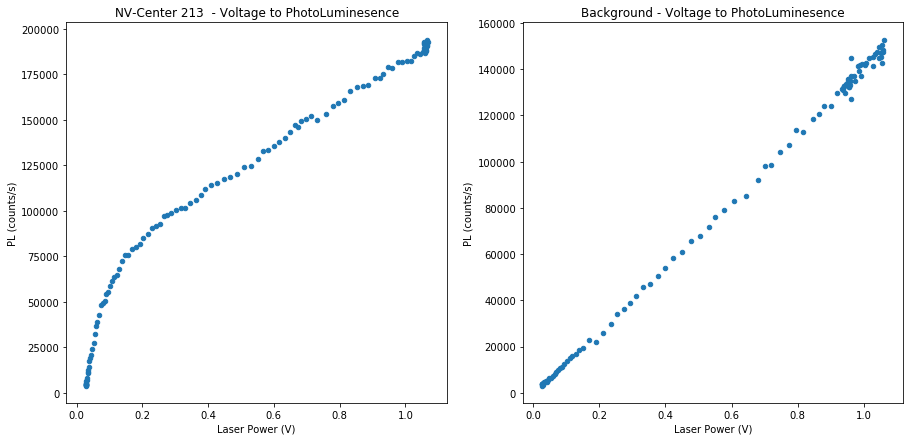

In [7]:
nv, b = compose_experiment(535, 3)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,7))  # 1 row, 2 columns
nv.plot.scatter(x='Laser Power (V)', y='PL (counts/s)', ax=ax1, title=f"NV-Center {SAMPLE_NUMBER}  - Voltage to PhotoLuminesence")
b.plot.scatter(x='Laser Power (V)', y='PL (counts/s)', ax=ax2, title="Background - Voltage to PhotoLuminesence")

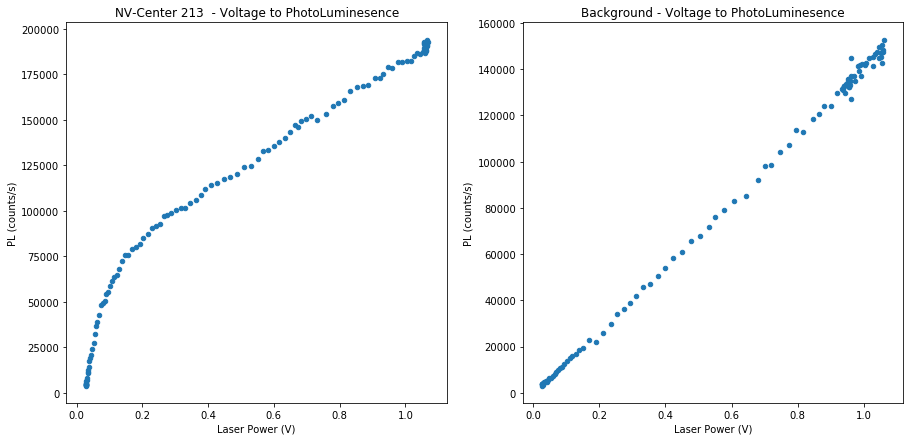

In [9]:
nv, b = compose_experiment(535, 3)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,7))  # 1 row, 2 columns
nv.plot(x='Laser Power (V)', y='PL (counts/s)', ax=ax1, kind='scatter', title=f"NV-Center {SAMPLE_NUMBER}  - Voltage to PhotoLuminesence")
b.plot(x='Laser Power (V)', y='PL (counts/s)', ax=ax2, kind='scatter', title="Background - Voltage to PhotoLuminesence")

Let's visualize some random, seemingly unrelated columns for good fun

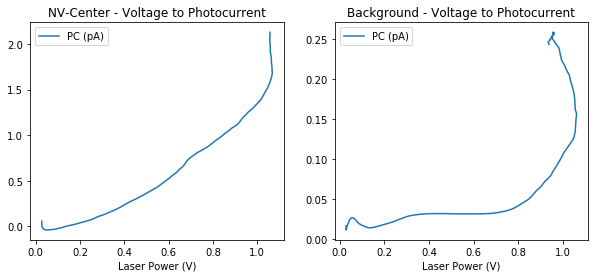

In [9]:
nv, b = compose_experiment(535, 3)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
nv.plot(x='Laser Power (V)', y='PC (pA)', ax=ax1, title="NV-Center - Voltage to Photocurrent", kind='line')
b.plot(x='Laser Power (V)', y='PC (pA)', ax=ax2, title="Background - Voltage to Photocurrent", kind='line')

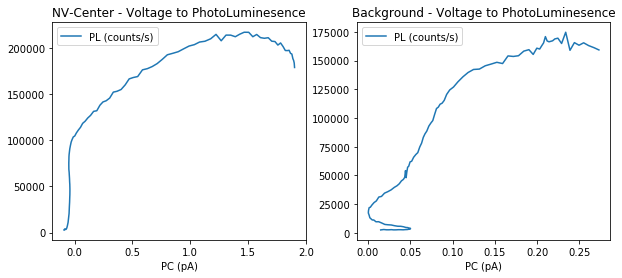

In [10]:
nv, b = compose_experiment(555, 2)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
nv.plot(x='PC (pA)', y='PL (counts/s)', ax=ax1, title="NV-Center - Voltage to PhotoLuminesence")
b.plot(x='PC (pA)', y='PL (counts/s)', ax=ax2, title="Background - Voltage to PhotoLuminesence")

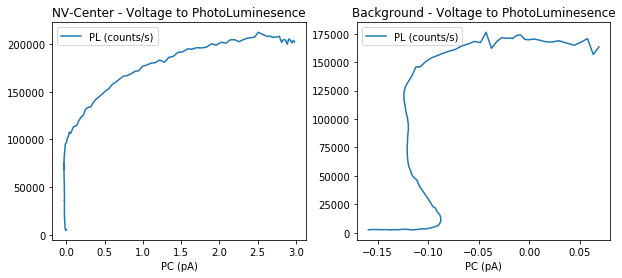

In [11]:
nv, b = compose_experiment(555, 3)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
nv.plot(x='PC (pA)', y='PL (counts/s)', ax=ax1, title="NV-Center - Voltage to PhotoLuminesence")
b.plot(x='PC (pA)', y='PL (counts/s)', ax=ax2, title="Background - Voltage to PhotoLuminesence")

## Basic Fitting

In this section, we'll be building up the code from the ground up, to fit the `Laser Power x PL relationship`, measured on the background.

If everything works well in this section, we can bundle everything nicely into automatable functions, and process all experiments at once. After this comes the opportunity for visualization, and analysis.

In [11]:
from sklearn.linear_model import LinearRegression # linear regression
from sklearn.model_selection import train_test_split # split dataset into train & testing
from sklearn.metrics import mean_squared_error # calculate error

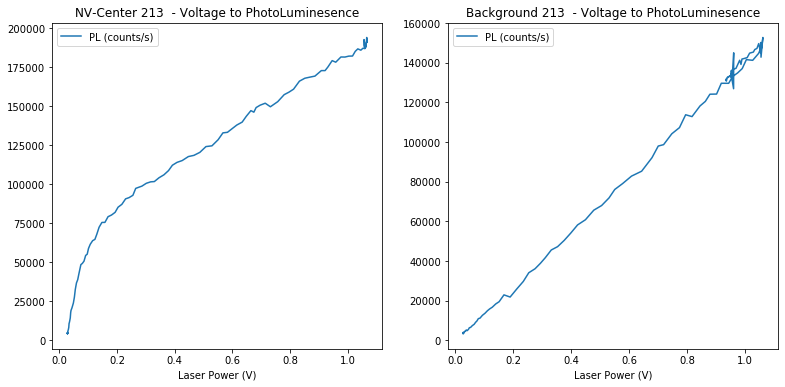

In [12]:
# get single data sample
nv, b = compose_experiment(535, 3)

# showcase Laser Power x PL
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(13,6))  # 1 row, 2 columns
nv.plot(x='Laser Power (V)', y='PL (counts/s)', ax=ax1, title=f"NV-Center {SAMPLE_NUMBER}  - Voltage to PhotoLuminesence")
b.plot(x='Laser Power (V)', y='PL (counts/s)', ax=ax2, title=f"Background {SAMPLE_NUMBER}  - Voltage to PhotoLuminesence")

Here's a basic way to fit in python using scikitlearn.

mean_absolute_error: 1240.2160364846823  - max_error: 3778.1929856469505


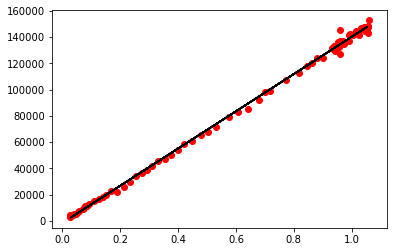

In [13]:
from sklearn.model_selection import train_test_split # split dataset into train & testing
from sklearn.metrics import max_error, mean_absolute_error # calculate error

# fit background PL(V) function, should be linear
X = b['Laser Power (V)'].to_numpy()
y = b['PL (counts/s)'].to_numpy()

# reshape data - [a,b,c,d] -> [[a], [b], [c], [d]] (because we have 1 feature for X)
X = X.reshape(-1, 1)

# split dataset into 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

# fit regression
reg = LinearRegression().fit(X_train, y_train)

# predict on unseen values (X_test)
y_pred = reg.predict(X_test)

# plot input values, and fit
plt.scatter(X_train, y_train,color='r') 
plt.plot(X_test, y_pred,color='k')

print("mean_absolute_error:", mean_absolute_error(y_test,y_pred), " - max_error:", max_error(y_test,y_pred))

This looks good enough! Let's subtract the **background PL counts** from NV-Center Counts, using the trained logistic regression.

In [14]:
# conver the column into a readily base for regressing
laser_power_nv = nv['Laser Power (V)'].to_numpy().reshape(-1,1)

# apply PL-count Regression
nv['PL_background'] = reg.predict(laser_power_nv)

# subtract background counts from NV counts
nv['PL_actual (#/s)'] = nv['PL (counts/s)'] - nv['PL_background']

And to visualize our results

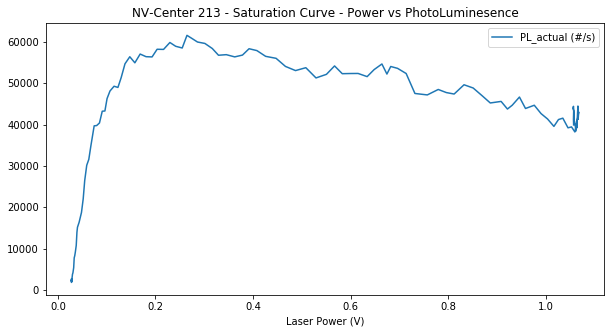

In [15]:
fig, (ax1) = plt.subplots(1,1, figsize=(10,5))  # 1 row, 2 columns
nv.plot(x='Laser Power (V)', y='PL_actual (#/s)', ax=ax1, title=f"NV-Center {SAMPLE_NUMBER} - Saturation Curve - Power vs PhotoLuminesence")

Looks good! For our next task:

> Let's add a simple regression technique, to convert laserpower from `Voltage` to `Watt`.

In [16]:
# read power to voltage data
df_pwr = pd.read_excel('laser power PDA (v) - powermeter (mW).xls', sheet_name="RAW", header=1)
df_pwr.head()

,535_V,535_mW,540_V,540_mW,545_V,545_mW,550_V,550_mW,555_V,555_mW,560_V,560_mW,565_V,565_mW,570_V,570_mW
0,0.149901,2.09,0.698322,3.89,0.253417,3.83,0.559756,3.87,0.362297,2.03,0.436171,2.49,0.289654,1.82,0.190533,1.90
1,0.606531,9.96,1.999350,11.44,1.033490,17.42,1.158700,8.23,2.283080,13.72,1.264840,7.60,2.261040,16.04,0.731263,8.76
2,1.311780,21.90,4.765400,27.50,1.926120,32.80,4.550870,33.00,4.105090,25.00,5.388710,33.00,4.683580,33.60,2.898430,36.50


In [17]:
def get_laser_pwr_fits_V_to_W():
	# read power to voltage data
	df_pwr = pd.read_excel('laser power PDA (v) - powermeter (mW).xls', sheet_name="RAW", header=1)

	# for each wavelength, store a linear regression
	regression_models = {}

	# make a list of available wavelengths
	wavelengths = [535+x*5 for x in range(8)]

	for w in wavelengths:

		# fit background PL(V) function, should be linear
		X = df_pwr[f'{w}_V'].to_numpy()
		y = df_pwr[f'{w}_mW'].to_numpy()

		# reshape data - [a,b,c,d] -> [[a], [b], [c], [d]] (because we have 1 feature for X)
		X = X.reshape(-1, 1)

		# fit regression
		reg = LinearRegression().fit(X, y)

		# store fit
		regression_models[w] = reg

		# predict on unseen values (X_test)
		y_pred = reg.predict(X)

		# plot input values, and fit
		plt.scatter(X, y,color='r') 
		plt.plot(X, y_pred,color='k')
	
	return regression_models

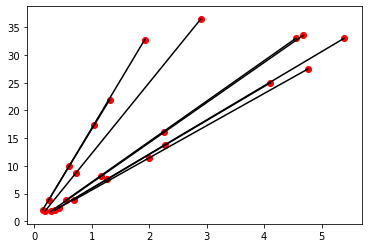

In [18]:
laser_pwr_V_to_W = get_laser_pwr_fits_V_to_W()

In [20]:
laser_pwr_V_to_W

{535: LinearRegression(),
 540: LinearRegression(),
 545: LinearRegression(),
 550: LinearRegression(),
 555: LinearRegression(),
 560: LinearRegression(),
 565: LinearRegression(),
 570: LinearRegression()}

Let's convert `Laser Power (V)` to `Laser Power (mW)`

In [21]:
# conver the column into a readily base for regressing
laser_power_nv = nv['Laser Power (V)'].to_numpy().reshape(-1,1)
wavelength = nv['Wavelength'][0]

# apply PL-count Regression
nv['Laser Power (mW)'] = laser_pwr_V_to_W[wavelength].predict(laser_power_nv)

And plot the results

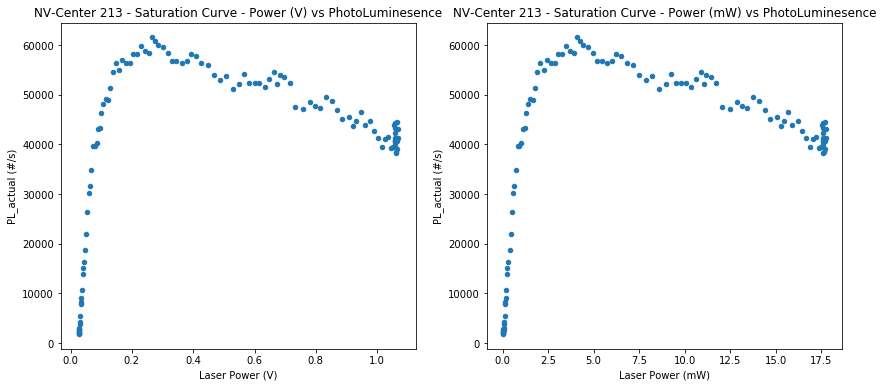

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))  # 1 row, 2 columns
nv.plot(x='Laser Power (V)', y='PL_actual (#/s)', ax=ax1, kind='scatter', title=f"NV-Center {SAMPLE_NUMBER} - Saturation Curve - Power (V) vs PhotoLuminesence")
nv.plot(x='Laser Power (mW)', y='PL_actual (#/s)', ax=ax2, kind='scatter', title=f"NV-Center {SAMPLE_NUMBER} - Saturation Curve - Power (mW) vs PhotoLuminesence")

Looks good! Let's turn everything into one nice function

## Define Automation

In [23]:
def get_params(filename):
	""" Retrieve parameters from a filename """

	id_string = filename.split('/')[1][17:]

	# pluck identifying information
	cc = id_string.split('-') # split into parts with - inbetween
		
	wavelength = cc[0]; # wavelength
	location = cc[1]; # background (b) or nv-center (nv)
	ix = cc[2].split('.')[0]; # experiment #

	return wavelength, location, ix

In [24]:
def read_filename(filename):
	""" Data preparation of a single experiment file """

	# read table
	df = pd.read_csv(filename, sep='\t', decimal='.', header=None)

	# EG, FILENAME='PL_PC_records/PL and PC record-535-b-2.txt' --> ID_STRING='535-b-2.txt'
	id_string = filename.split('/')[1][17:]

	# pluck identifying information
	cc = id_string.split('-') # split into parts with - inbetween
	wavelength = cc[0]; # wavelength
	location = cc[1]; # background (b) or nv-center (nv)
	ix = cc[2].split('.')[0]; # experiment #

	# file has rows for columns, thus transpose
	df = df.transpose()

	# assign column meaning
	df['Laser Power (V)'] = df[0] # the header became the index after transposition
	df['PL (counts/s)'] = df[1]
	df['PC (pA)'] = df[2]

	# make the index a simple counter
	df = df.reset_index()

	# keep columns of interest
	df = df[['Laser Power (V)', 'PL (counts/s)', 'PC (pA)']]

	# assign identifiers to dataframe
	df['Wavelength'] = int(wavelength)
	df['Location'] = location
	df['Experiment #'] = ix

	df['Laser Power (V)'] = df['Laser Power (V)'].astype(float)
	df['PL (counts/s)'] = df['PL (counts/s)'].astype(float)
	df['PC (pA)'] =  df['PC (pA)'].astype(float)

	return df, wavelength, location, ix

In [25]:
def compose_experiment(wavelength, iteration):
    """ Gather background and NV data, and return pair """
    
    nv_filename = 'PL_PC_records/PL and PC record-' + str(wavelength) + '-nv-' + str(iteration) + '.txt'
    b_filename  = 'PL_PC_records/PL and PC record-' + str(wavelength) + '-b-' + str(iteration) + '.txt'
    
    print (f"reading nv - {wavelength} - {iteration}")
    nv_df, _ , _ , _  = read_filename(nv_filename)
    
    print (f"reading b - {wavelength} - {iteration}")
    b_df , _ , _ , _ = read_filename(b_filename)	
    
    return nv_df, b_df

In [26]:
def get_laser_pwr_fits_V_to_W():
	""" This function reads an excel sheet with experimental data, and spits out 8 linear regressions  """
	# read power to voltage data
	df_pwr = pd.read_excel('laser power PDA (v) - powermeter (mW).xls', sheet_name="RAW", header=1)

	# for each wavelength, store a linear regression
	regression_models = {}

	# make a list of available wavelengths
	wavelengths = [535+x*5 for x in range(8)]

	for w in wavelengths:

		# fit background PL(V) function, should be linear
		X = df_pwr[f'{w}_V'].to_numpy()
		y = df_pwr[f'{w}_mW'].to_numpy()

		# reshape data - [a,b,c,d] -> [[a], [b], [c], [d]] (because we have 1 feature for X)
		X = X.reshape(-1, 1)

		# fit regression
		reg = LinearRegression().fit(X, y)

		# store fit
		regression_models[w] = reg

		# predict on unseen values (X_test)
		y_pred = reg.predict(X)

		# plot input values, and fit
		plt.scatter(X, y,color='r') 
		plt.plot(X, y_pred,color='k')
	
	return regression_models

In [27]:
def get_saturation_curve(wavelength, iteration):

	# get nv-center and background data
	nv, b = compose_experiment(wavelength, iteration)

	# fit background PL(V) function, should be linear
	X = b['Laser Power (V)'].to_numpy()
	y = b['PL (counts/s)'].to_numpy()

	# reshape data - [a,b,c,d] -> [[a], [b], [c], [d]] (because we have 1 feature for X)
	X = X.reshape(-1, 1)

	# split dataset into 80% for training, 20% for testing
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

	# fit regression
	reg = LinearRegression().fit(X_train, y_train)

	# predict on unseen values (X_test)
	y_pred = reg.predict(X_test)
	metric_mean_err = mean_absolute_error(y_test,y_pred)
	metric_max_err = max_error(y_test,y_pred)
	print("mean_absolute_error:", mean_absolute_error(y_test,y_pred), " - max_error:", max_error(y_test,y_pred))

	########## SUBTRACT BACKGROUND

	# conver the column into a readily base for regressing
	laser_power_nv = nv['Laser Power (V)'].to_numpy().reshape(-1,1)

	# apply PL-count Regression
	nv['PL_background'] = reg.predict(laser_power_nv)

	# subtract background counts from NV counts
	nv['PL_NV (#/s)'] = nv['PL (counts/s)'] - nv['PL_background']

	########## POWER - VOLTAGE to WATTAGE

	# conver the column into a vector for regression
	laser_power_nv_X = nv['Laser Power (V)'].to_numpy().reshape(-1,1)

	# apply PL-count Regression
	nv['Laser Power (mW)'] = laser_pwr_V_to_W[int(wavelength)].predict(laser_power_nv_X)
	
	return nv, {'wavelength': int(wavelength), 'iteration': int(iteration), 'metric_mean_err':metric_mean_err, 'metric_mean_err':metric_max_err }



## Run Automation (single file)

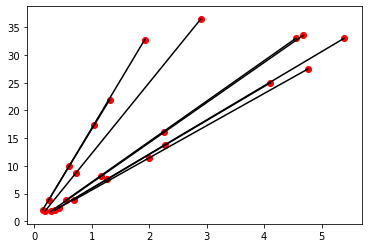

In [28]:
# get laser power regressions (V to W)
laser_pwr_V_to_W = get_laser_pwr_fits_V_to_W()

In [29]:
laser_pwr_V_to_W

{535: LinearRegression(),
 540: LinearRegression(),
 545: LinearRegression(),
 550: LinearRegression(),
 555: LinearRegression(),
 560: LinearRegression(),
 565: LinearRegression(),
 570: LinearRegression()}

In [30]:
laser_pwr_V_to_W[535].predict([[2.30]])

array([38.76082415])

reading nv - 535 - 1
reading b - 535 - 1
mean_absolute_error: 2107.9861035558815  - max_error: 17686.63527555039


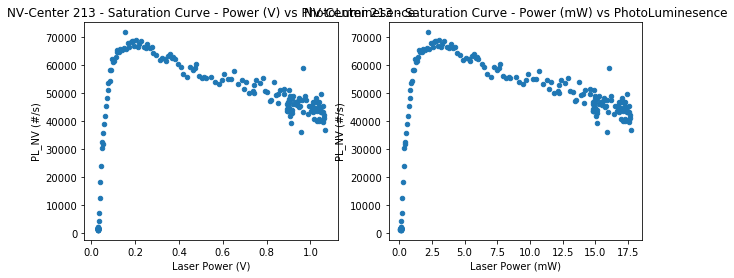

In [31]:
df, metrics = get_saturation_curve(535, 1)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
df.plot.scatter(x='Laser Power (V)', y='PL_NV (#/s)', ax=ax1, title=f"NV-Center {SAMPLE_NUMBER} - Saturation Curve - Power (V) vs PhotoLuminesence")
df.plot.scatter(x='Laser Power (mW)', y='PL_NV (#/s)', ax=ax2, title=f"NV-Center {SAMPLE_NUMBER} - Saturation Curve - Power (mW) vs PhotoLuminesence")


In [32]:
## Run Over All Files

all_saturation_curves = [] # will store all saturation curves
all_saturation_curves_on_wavelength = {} # dict: { wavelength: df_saturation curve }
experiments_done = {}

# determine a cood metric for a good experiment
metrics_df = pd.DataFrame()

# import required module
import os
# assign directory
directory = 'PL_PC_records'
FILE_PREFIX_CHECK = 'PL and PC record'
 
# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):

        # skip if this isn't out file
        prefx = f.split('/')[1][:16]
        if prefx != FILE_PREFIX_CHECK:
            continue

        # extract parameters
        wavelength, loc, exp_iter = get_params(f)
        
        # skip iteration, if we've processed this wavelength and experiment number
        if wavelength in experiments_done:
            if exp_iter in experiments_done[wavelength]:
                continue
                
        print (f"processing {wavelength} - Experiment {exp_iter}")

        # create saturation curve for this particullar wavelength, and exp_iter
        df, metrics = get_saturation_curve(wavelength, exp_iter)
        all_saturation_curves.append(df)
        
        metrics_df.append(metrics, ignore_index=True);

        # register that we've processed this experiment
        if wavelength not in experiments_done:
            experiments_done[wavelength] = []
            all_saturation_curves_on_wavelength[wavelength] = []
            
            # append dataframe
            all_saturation_curves_on_wavelength[wavelength].append(df)
            
            # append id, such that we won't process this dataframe upon coupled entries
            experiments_done[wavelength].append(exp_iter)
        else:
            
            # append dataframe
            all_saturation_curves_on_wavelength[wavelength].append(df)
            
            # append id, such that we won't process this dataframe upon coupled entries
            experiments_done[wavelength].append(exp_iter)
            
            

processing 540 - Experiment 3
reading nv - 540 - 3
reading b - 540 - 3
mean_absolute_error: 2125.18177016909  - max_error: 5466.759217591549
processing 550 - Experiment 3
reading nv - 550 - 3
reading b - 550 - 3
mean_absolute_error: 2305.8506700143043  - max_error: 6104.918009894958
processing 565 - Experiment 1
reading nv - 565 - 1
reading b - 565 - 1
mean_absolute_error: 4509.055393896723  - max_error: 9856.569731183467
processing 550 - Experiment 2
reading nv - 550 - 2
reading b - 550 - 2
mean_absolute_error: 2091.805063689067  - max_error: 5293.1121938216675
processing 540 - Experiment 2
reading nv - 540 - 2
reading b - 540 - 2
mean_absolute_error: 1000.3434840644404  - max_error: 3075.293432359118
processing 565 - Experiment 2
reading nv - 565 - 2
reading b - 565 - 2
mean_absolute_error: 2703.2349457073897  - max_error: 8374.047784891853
processing 565 - Experiment 3
reading nv - 565 - 3
reading b - 565 - 3
mean_absolute_error: 7233.8573280086275  - max_error: 26471.186878581764
p

In [33]:
all_saturation_curves[0]

,Laser Power (V),PL (counts/s),PC (pA),Wavelength,Location,Experiment #,PL_background,PL_NV (#/s),Laser Power (mW)
0,0.032747,10325.028196,-0.411735,540,nv,3,7399.714483,2925.313713,0.024979
1,0.033838,10620.601408,-0.413115,540,nv,3,7449.182194,3171.419214,0.031313
2,0.034525,10706.078136,-0.414286,540,nv,3,7480.331889,3225.746247,0.035301
3,0.034682,10899.848477,-0.415383,540,nv,3,7487.450523,3412.397954,0.036212
4,0.036316,10434.239300,-0.416749,540,nv,3,7561.538735,2872.700565,0.045698
...,...,...,...,...,...,...,...,...,...
101,3.247179,169182.886608,2.296507,540,nv,3,153147.277958,16035.608650,18.685725
102,3.232938,187444.404683,2.307022,540,nv,3,152501.567907,34942.836776,18.603052
103,3.224477,190243.540794,2.314935,540,nv,3,152117.932435,38125.608359,18.553933
104,3.217187,186404.711595,2.321262,540,nv,3,151787.392005,34617.319590,18.511613


In [35]:
# df_saturations_all = pd.DataFrame()

# for df in all_saturation_curves:
#     wavelength = df['wavelength'][0]
#     exp_number = df['Experiment #'][0]
    
#     power = df['Laser Power (mW)']
#     PL = df['PL_NV (#/s)']
    
#     df_saturations_all['wavelength'] = 

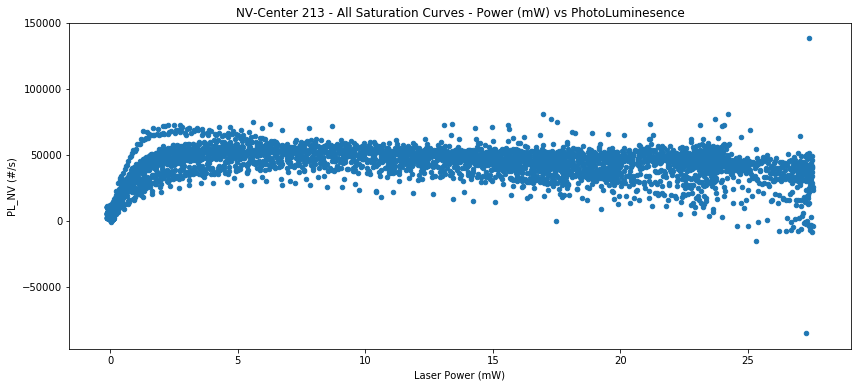

In [36]:
df = all_saturation_curves[0]

fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns

for df in all_saturation_curves:
	df.plot.scatter(x='Laser Power (mW)', y='PL_NV (#/s)', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - All Saturation Curves - Power (mW) vs PhotoLuminesence")
    

In [37]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

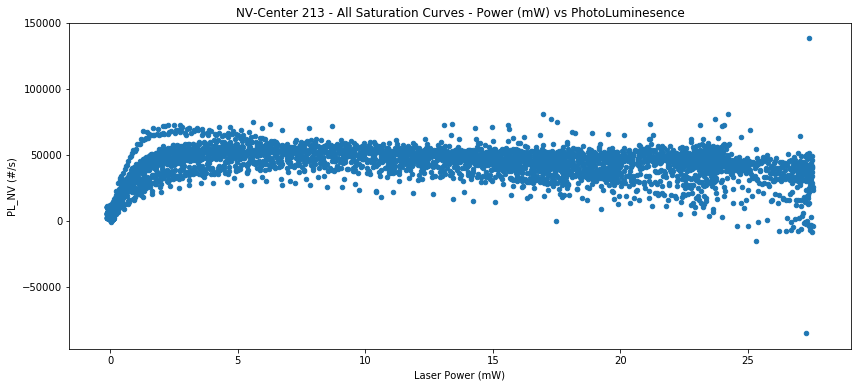

In [38]:
df = all_saturation_curves[0]

fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns

for df in all_saturation_curves:
	df.plot.scatter(x='Laser Power (mW)', y='PL_NV (#/s)', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - All Saturation Curves - Power (mW) vs PhotoLuminesence")
    

In [39]:
def plot_experiments_at_wavelength_ax(wavelength, ax1):
    """ This thing plots directly to the axis """
    dfs = all_saturation_curves_on_wavelength[wavelength]

    plasma = cm.get_cmap('plasma', len(dfs))
    colors = plasma(range(len(dfs)))

    for ii, df in enumerate(dfs):

        x = df['Laser Power (mW)'].to_numpy()
        y = df['PL_NV (#/s)'].to_numpy()
        wavelength = df['Wavelength'][0]
        exp_no = df['Experiment #'][0]

        ax1.scatter(x, y, s=4, c=[colors[ii]], label=f'{wavelength}-{exp_no}', alpha=0.8)

    ax1.set_title(f"NV-Center Saturation Curve - @{wavelength}nm")
    ax1.set_xlabel("Laser Power (mW)")
    ax1.set_ylabel("Photoluminescence (#/s)")
    ax1.legend()
    ax1.grid(True)

In [40]:
def plot_experiments_at_wavelength(wavelength):
    dfs = all_saturation_curves_on_wavelength[wavelength]
    fig, (ax1) = plt.subplots(1,1, figsize=(10,6))  # 1 row, 2 columns

    plasma = cm.get_cmap('plasma', len(dfs))
    colors = plasma(range(len(dfs)))

    for ii, df in enumerate(dfs):

        x = df['Laser Power (mW)'].to_numpy()
        y = df['PL_NV (#/s)'].to_numpy()
        wavelength = df['Wavelength'][0]
        exp_no = df['Experiment #'][0]

        ax1.scatter(x, y, s=4, c=[colors[ii]], label=f'{wavelength}-{exp_no}', alpha=0.8)

    ax1.set_title(f"NV-Center Saturation Curve - @{wavelength}nm")
    
    ax1.set_xlabel("Laser Power (mW)")
    ax1.set_ylabel("Photoluminescence (#/s)")
    ax1.legend()
    ax1.grid(True)

Lets plot a grid, seperated on wavelength

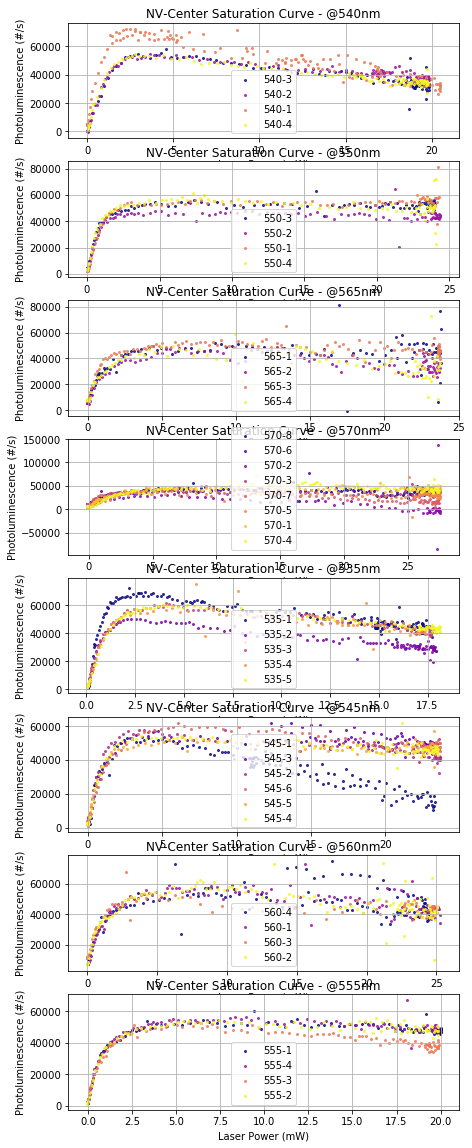

In [41]:
fig, axes = plt.subplots(8, 1, figsize=(7,20))  # 1 row, 2 columns

axes.shape

ii = 0
for kk, dfs in all_saturation_curves_on_wavelength.items():
    ax = axes[ii]
    plot_experiments_at_wavelength_ax(kk, ax)
    
    ii+=1

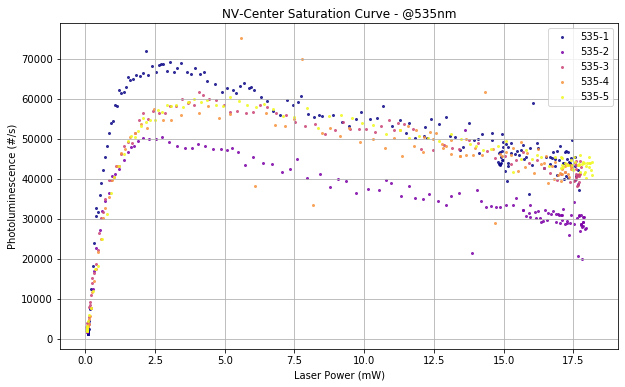

In [65]:
plot_experiments_at_wavelength('535')

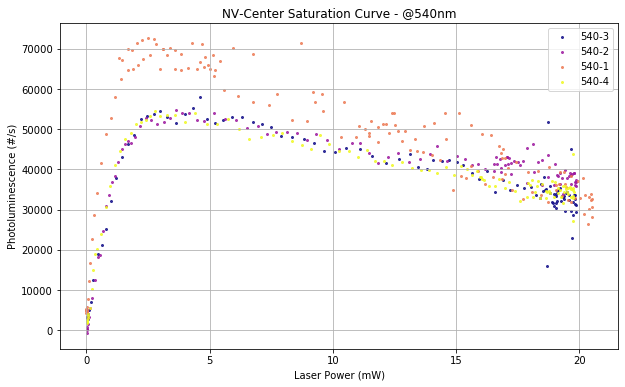

In [66]:
plot_experiments_at_wavelength('540')

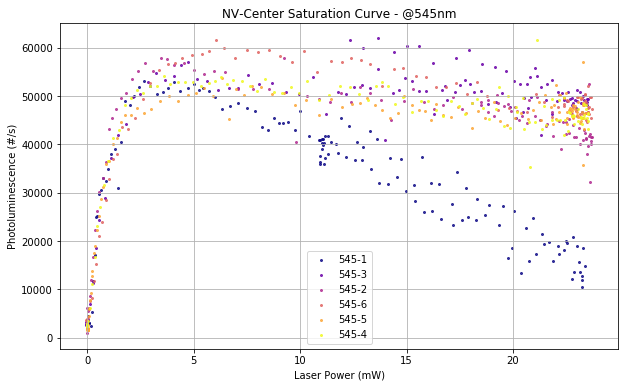

In [67]:
plot_experiments_at_wavelength('545')

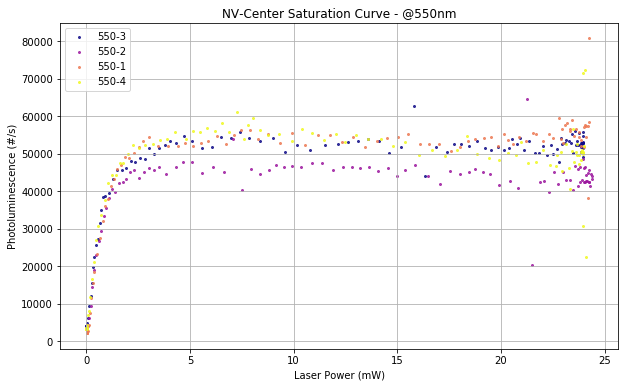

In [68]:
plot_experiments_at_wavelength('550')

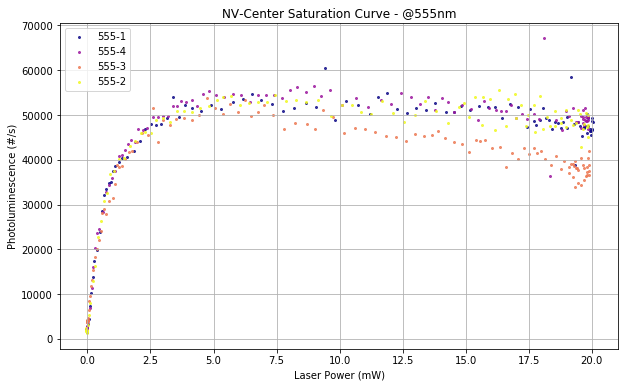

In [70]:
plot_experiments_at_wavelength('555')

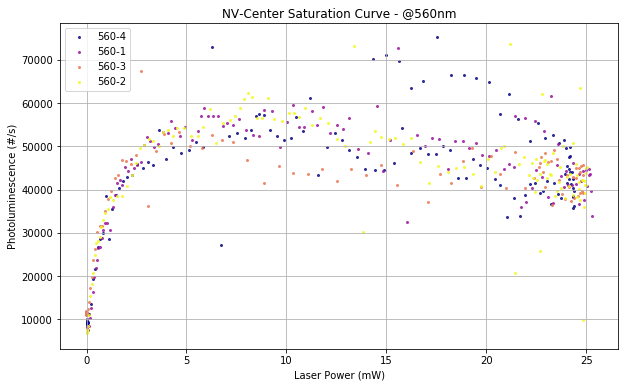

In [69]:
plot_experiments_at_wavelength('560')

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Curve fitting



In [143]:
def func_to_fit(x, a, b, c, d, e):
    return (a*(x**2) + b*x) / (c*(x**2) + d*x + e)

In [144]:
all_saturation_curves[0]

,Laser Power (V),PL (counts/s),PC (pA),Wavelength,Location,Experiment #,PL_background,PL_NV (#/s),Laser Power (mW)
0,0.032747,10325.028196,-0.411735,540,nv,3,7399.714483,2925.313713,0.024979
1,0.033838,10620.601408,-0.413115,540,nv,3,7449.182194,3171.419214,0.031313
2,0.034525,10706.078136,-0.414286,540,nv,3,7480.331889,3225.746247,0.035301
3,0.034682,10899.848477,-0.415383,540,nv,3,7487.450523,3412.397954,0.036212
4,0.036316,10434.239300,-0.416749,540,nv,3,7561.538735,2872.700565,0.045698
...,...,...,...,...,...,...,...,...,...
101,3.247179,169182.886608,2.296507,540,nv,3,153147.277958,16035.608650,18.685725
102,3.232938,187444.404683,2.307022,540,nv,3,152501.567907,34942.836776,18.603052
103,3.224477,190243.540794,2.314935,540,nv,3,152117.932435,38125.608359,18.553933
104,3.217187,186404.711595,2.321262,540,nv,3,151787.392005,34617.319590,18.511613


Let's fit sample number 0

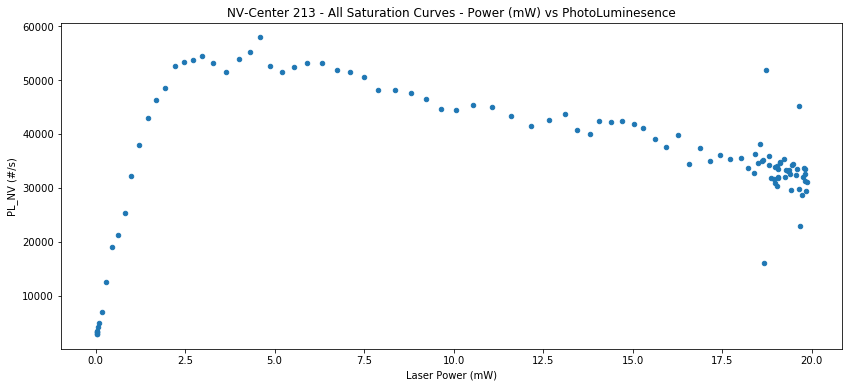

In [145]:
df = all_saturation_curves[0]
fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
df.plot.scatter(x='Laser Power (mW)', y='PL_NV (#/s)', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - All Saturation Curves - Power (mW) vs PhotoLuminesence")

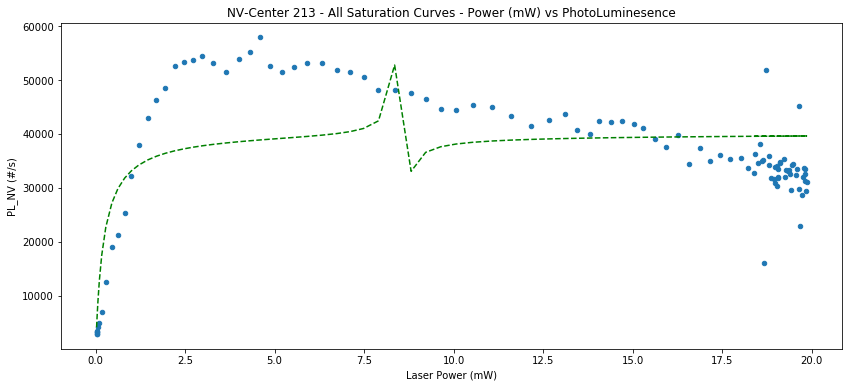

In [146]:
df = all_saturation_curves[0]

# data
x = df['Laser Power (mW)'].to_numpy()
y = df['PL_NV (#/s)'].to_numpy()

# function fit
popt, pcov = curve_fit(func_to_fit, x, y)
popt # contains fits for a-e

fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
df.plot.scatter(x='Laser Power (mW)', y='PL_NV (#/s)', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - All Saturation Curves - Power (mW) vs PhotoLuminesence")

plt.plot(x, func_to_fit(x, *popt), 'g--', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f, e=%5.3f' % tuple(popt))

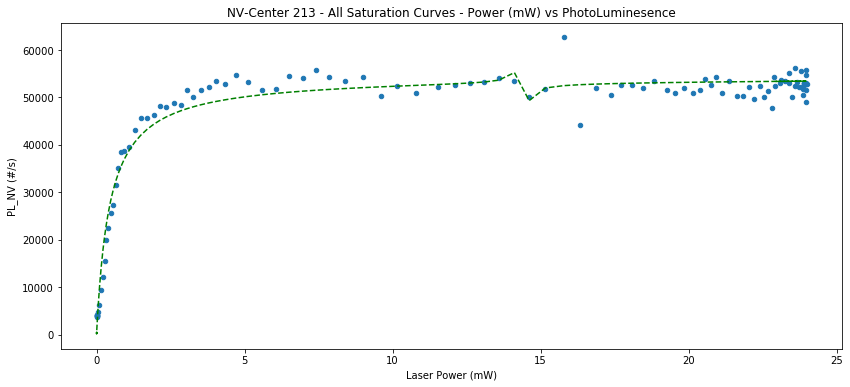

In [147]:
df = all_saturation_curves[1]

# data
x = df['Laser Power (mW)'].to_numpy()
y = df['PL_NV (#/s)'].to_numpy()

# function fit
popt, pcov = curve_fit(func_to_fit, x, y)
popt # contains fits for a-e

fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
df.plot.scatter(x='Laser Power (mW)', y='PL_NV (#/s)', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - All Saturation Curves - Power (mW) vs PhotoLuminesence")

plt.plot(x, func_to_fit(x, *popt), 'g--', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f, e=%5.3f' % tuple(popt))

[5.45830346e+01 2.78686548e+04 6.30622459e-03 4.93178928e-01
 3.85791055e-01]


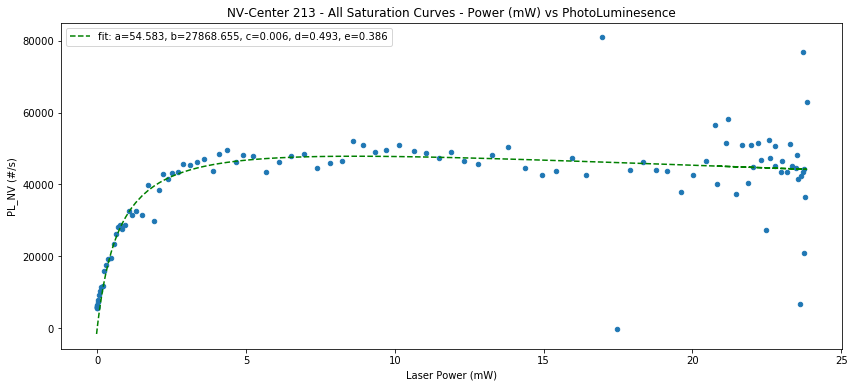

In [153]:
df = all_saturation_curves[2]

# data
x = df['Laser Power (mW)'].to_numpy()
y = df['PL_NV (#/s)'].to_numpy()

# function fit
popt, pcov = curve_fit(func_to_fit, x, y)
print(popt) # contains fits for a-e

fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
df.plot.scatter(x='Laser Power (mW)', y='PL_NV (#/s)', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - All Saturation Curves - Power (mW) vs PhotoLuminesence")

plt.plot(x, func_to_fit(x, *popt), 'g--', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f, e=%5.3f' % tuple(popt))
plt.legend()

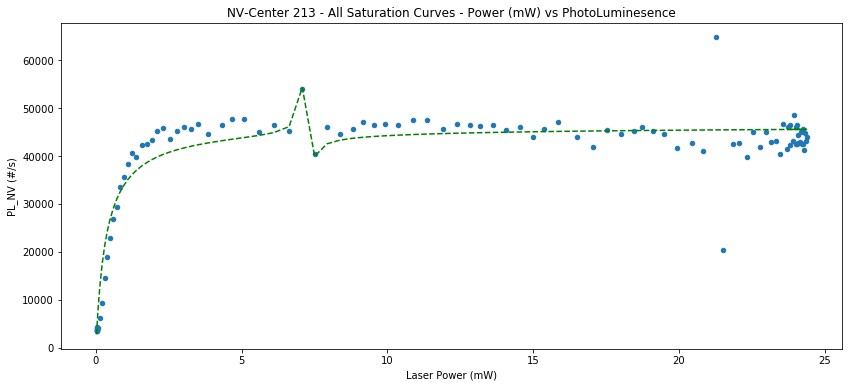

In [152]:
df = all_saturation_curves[3]

# data
x = df['Laser Power (mW)'].to_numpy()
y = df['PL_NV (#/s)'].to_numpy()


# function fit
popt, pcov = curve_fit(func_to_fit, x, y)
popt # contains fits for a-e

fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
df.plot.scatter(x='Laser Power (mW)', y='PL_NV (#/s)', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - All Saturation Curves - Power (mW) vs PhotoLuminesence")

plt.plot(x, func_to_fit(x, *popt), 'g--', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f, e=%5.3f' % tuple(popt))

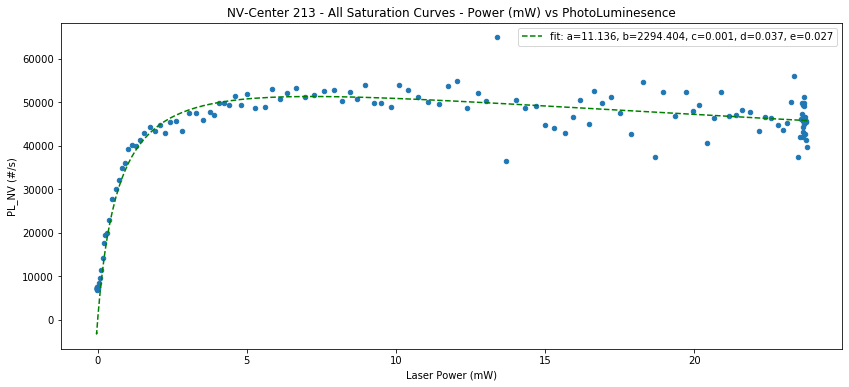

In [160]:
df = all_saturation_curves[6]

# data
x = df['Laser Power (mW)'].to_numpy()
y = df['PL_NV (#/s)'].to_numpy()

# function fit
popt, pcov = curve_fit(func_to_fit, x, y, bounds=[0, np.Inf])
popt # contains fits for a-e

fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
df.plot.scatter(x='Laser Power (mW)', y='PL_NV (#/s)', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - All Saturation Curves - Power (mW) vs PhotoLuminesence")

plt.plot(x, func_to_fit(x, *popt), 'g--', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f, e=%5.3f' % tuple(popt))

plt.legend()

Let's do it for a bunch of curves, for a given wavelength

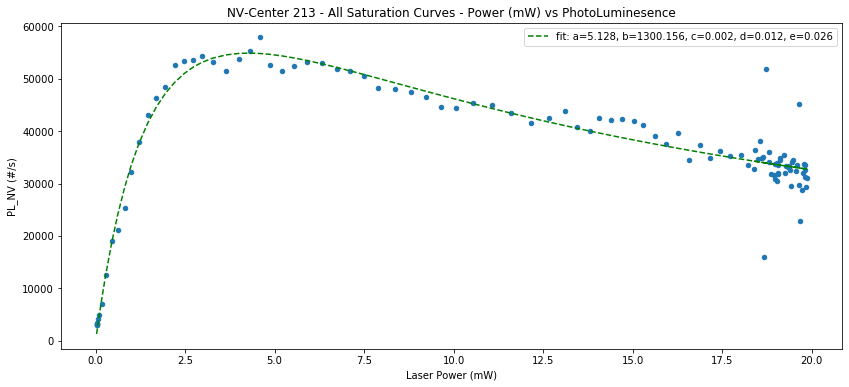

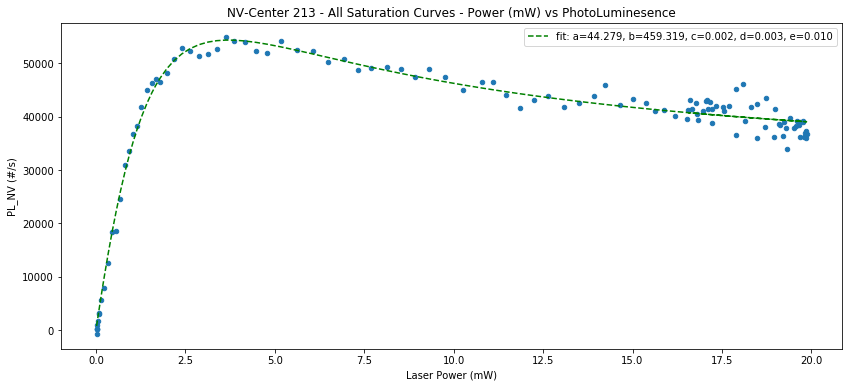

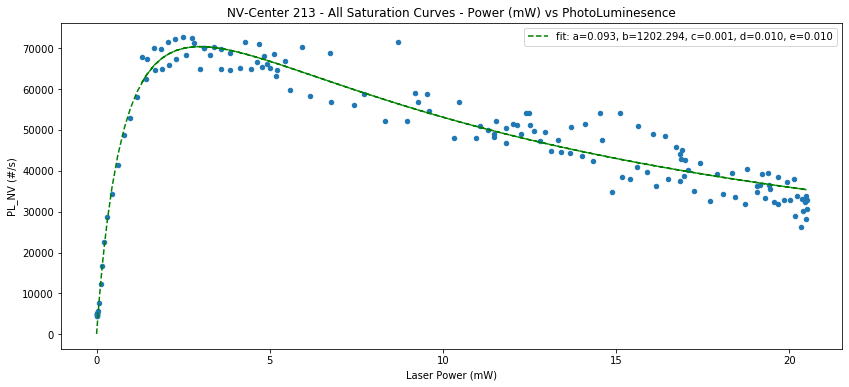

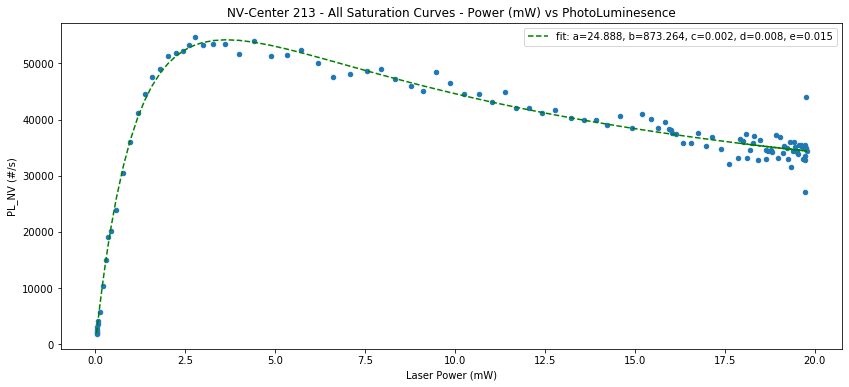

In [156]:
for df in all_saturation_curves_on_wavelength['540']:
	
	# data
	x = df['Laser Power (mW)'].to_numpy()
	y = df['PL_NV (#/s)'].to_numpy()

	# function fit
	popt, pcov = curve_fit(func_to_fit, x, y, bounds=[0, np.Inf])
	popt # contains fits for a-e

	fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
	df.plot.scatter(x='Laser Power (mW)', y='PL_NV (#/s)', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - All Saturation Curves - Power (mW) vs PhotoLuminesence")

	plt.plot(x, func_to_fit(x, *popt), 'g--', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f, e=%5.3f' % tuple(popt))

	plt.legend()

## k8 Fitting

In [68]:
km = 1.6E-6

0.0015999999999999999

In [113]:
a = 1

def func_to_fit(x, a, b, c, d, e):
    return (a*(x**2) + b*x) / (c*(x**2) + d*x + e)

def func_to_fit_test(x, a, b, c, d, e):

    u = 1.6E-6
    v = 50E-6

    return ((x**2) + (b*x/a)) / ((u*c/a)*(x**2) + (v*d/a)*x + (e/a))

def func_to_fit_2(x, e, a, b):

    c = 0.2
    d = 0.01

    return (e) / (1 + (1/(a*x)) + ((c*x)/(1+b*x)) + ((d)/(1+b*x)))

def func_to_fit_3(x, a, b, c, k, u, v):
    # a = kr
    # b = ke
    # c = kd
    # k = k8

    # u = km // literature constant
    # v = kn // literature constant

    # u = 1.6E-6
    # v = 50E-6

    # u = 1.6
    # v = 50

    return (b*x*(k*x+u)) / (a*k*x + a*u + b*c*(x**2) + b*k*(x**2) + b*u*x + b*v*x )

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [106]:
all_saturation_curves_on_wavelength['535'][0].dtypes

Laser Power (V)     float64
PL (counts/s)       float64
PC (pA)             float64
Wavelength            int64
Location             object
Experiment #         object
PL_background       float64
PL_NV (#/s)         float64
Laser Power (mW)    float64
dtype: object

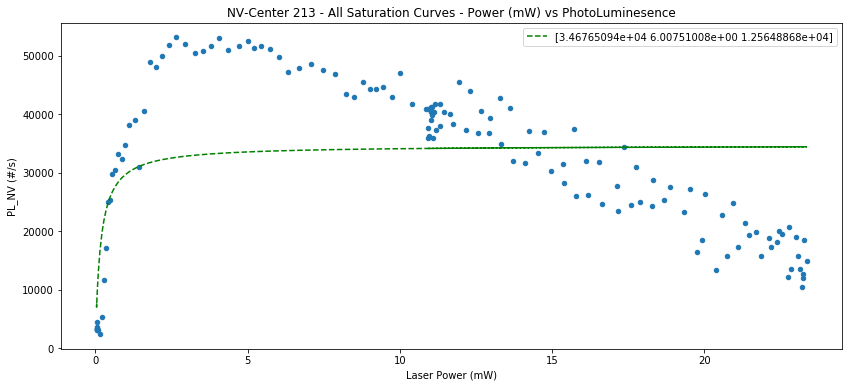

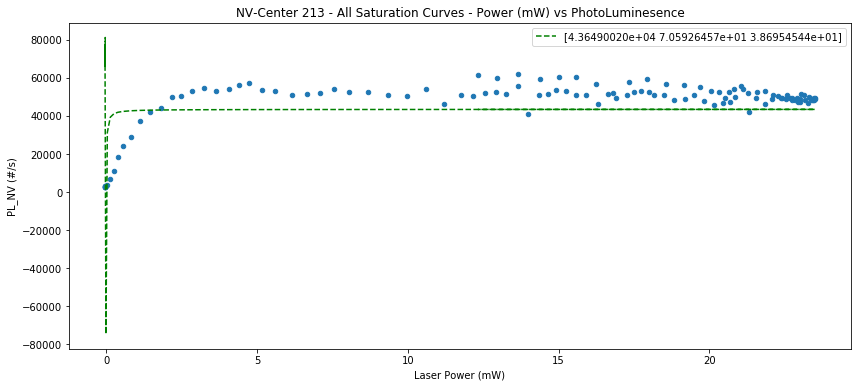

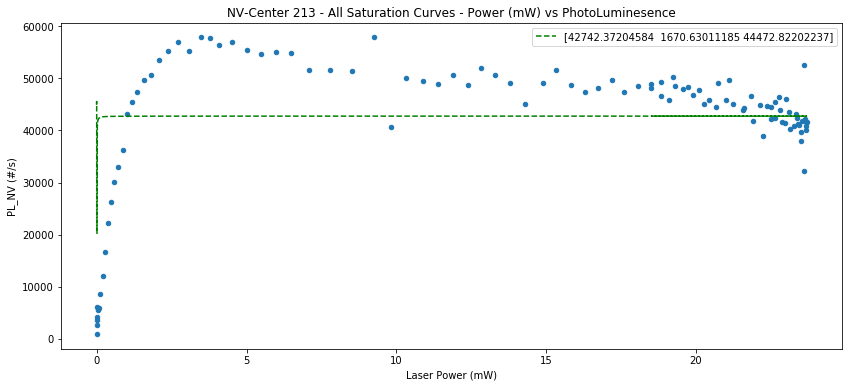

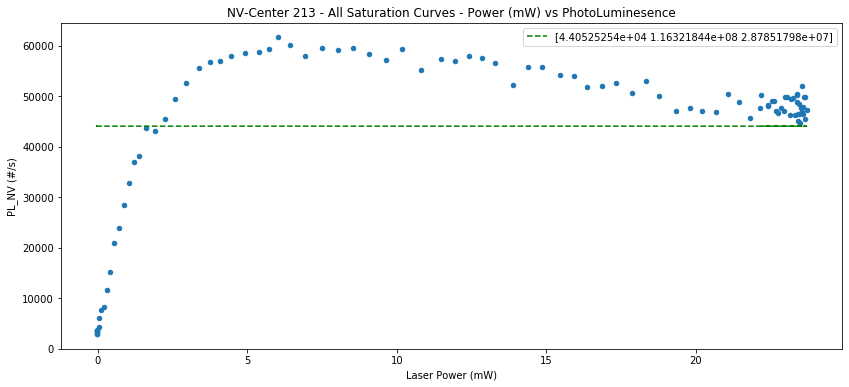

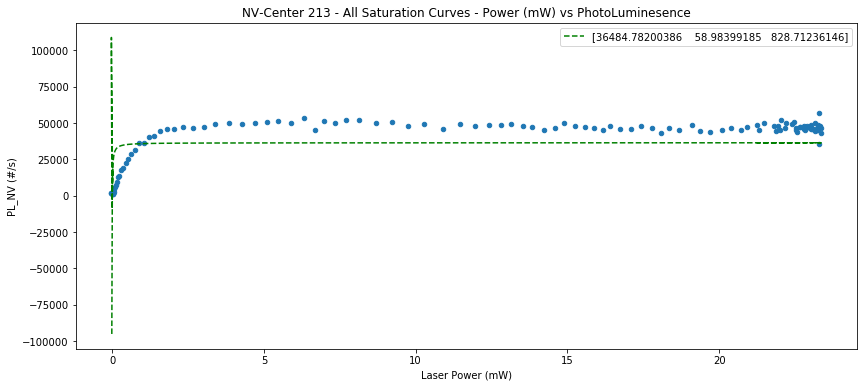

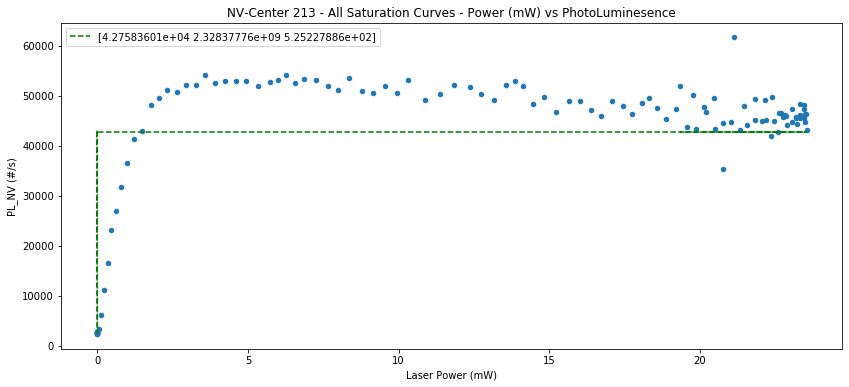

In [121]:
for df in all_saturation_curves_on_wavelength['545']:
	
	# data
	x = df['Laser Power (mW)'].to_numpy()
	y = df['PL_NV (#/s)'].to_numpy()

	# function fit
	popt, pcov = curve_fit(func_to_fit_2, x, y, bounds=[0, np.Inf], maxfev=100000)
	popt # contains fits for a-e

	fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
	df.plot.scatter(x='Laser Power (mW)', y='PL_NV (#/s)', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - All Saturation Curves - Power (mW) vs PhotoLuminesence")

	plt.plot(x, func_to_fit_2(x, *popt), 'g--', label=f'{popt}')

	plt.legend()

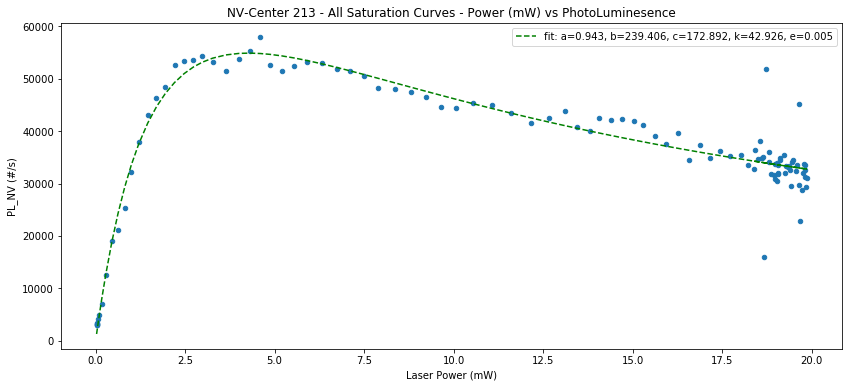

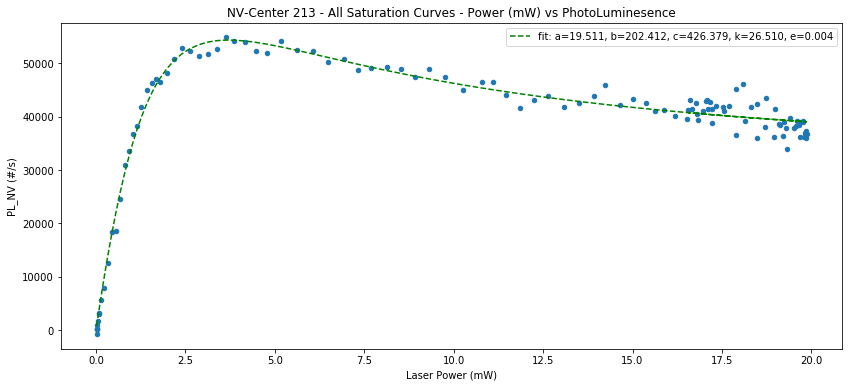

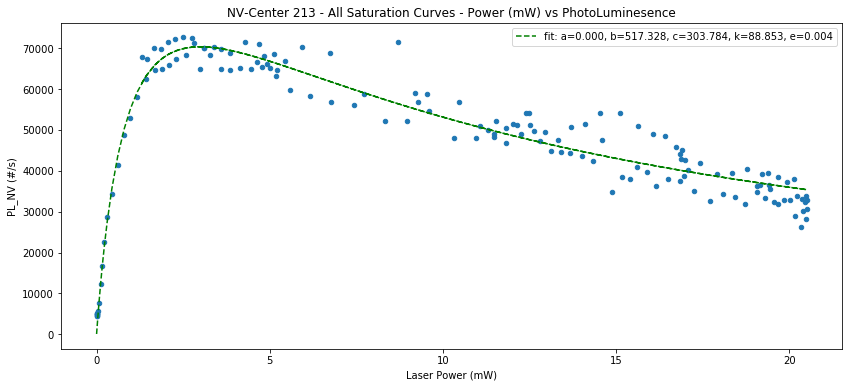

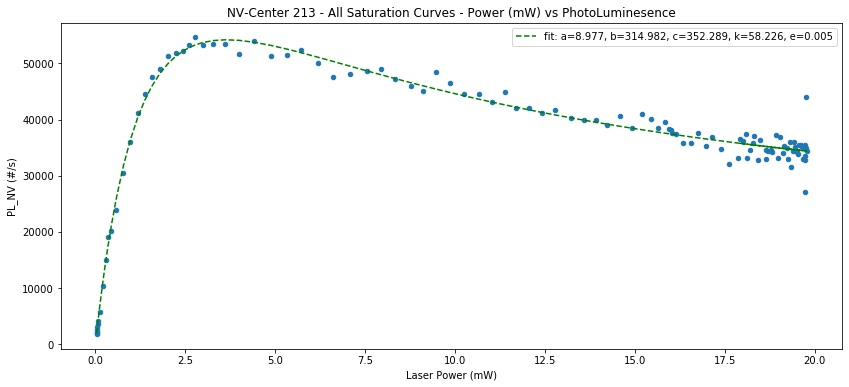

In [108]:
for df in all_saturation_curves_on_wavelength['540']:
	
	# data
	x = df['Laser Power (mW)'].to_numpy()
	y = df['PL_NV (#/s)'].to_numpy()

	# function fit
	popt, pcov = curve_fit(func_to_fit_test, x, y, bounds=[0, np.Inf])
	popt # contains fits for a-e

	fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
	df.plot.scatter(x='Laser Power (mW)', y='PL_NV (#/s)', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - All Saturation Curves - Power (mW) vs PhotoLuminesence")

	plt.plot(x, func_to_fit_test(x, *popt), 'g--', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, k=%5.3f, e=%5.3f' % tuple(popt))

	plt.legend()

# Plot in 3D

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 

In [42]:
%matplotlib notebook

In [52]:
[1,2,3,4,5,6]

[1, 2, 3, 4, 5, 6]

<IPython.core.display.Javascript object>


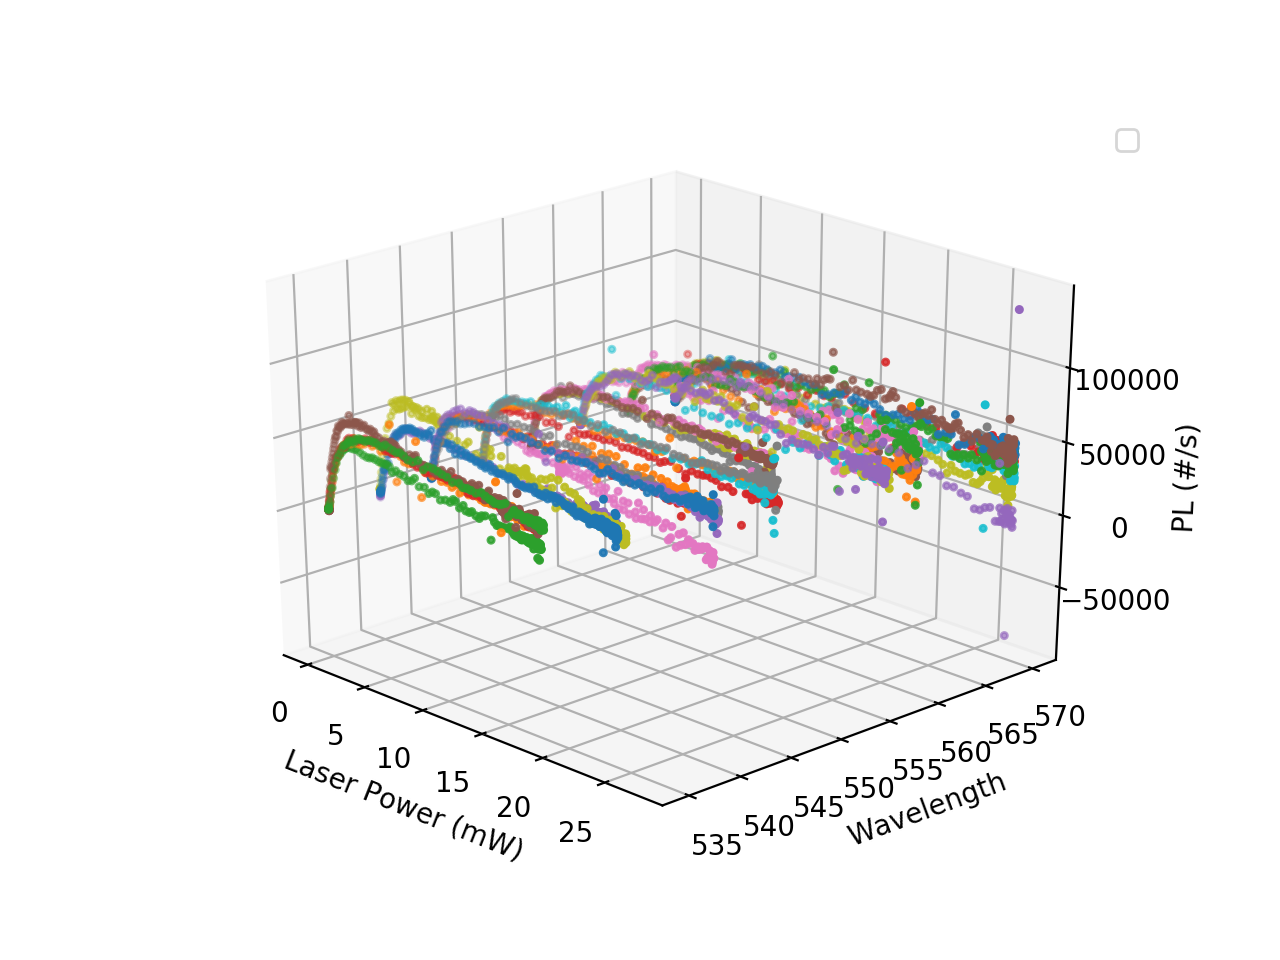

In [50]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n = 100

for df in all_saturation_curves.filter:
    xs = df['Laser Power (mW)']
    ys = df['Wavelength'][0]
    zs = df['PL_NV (#/s)']
    
    ax.scatter(xs, ys, zs, marker='.')
    
#     df.plot.scatter(x='Laser Power (mW)', y='PL_NV (#/s)', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Saturation Curve - Power (mW) vs PhotoLuminesence")

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
# for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
#     xs = randrange(n, 23, 32)
#     ys = randrange(n, 0, 100)
#     zs = randrange(n, zlow, zhigh)
#     ax.scatter(xs, ys, zs, marker=m)

ax.set_xlabel('Laser Power (mW)')
ax.set_ylabel('Wavelength')
ax.set_zlabel('PL (#/s)')

plt.show()

In [49]:
# show case a particular saturation curve
all_saturation_curves[0]

,Laser Power (V),PL (counts/s),PC (pA),Wavelength,Location,Experiment #,PL_background,PL_NV (#/s),Laser Power (mW)
0,0.032747,10325.028196,-0.411735,540,nv,3,7399.714483,2925.313713,0.024979
1,0.033838,10620.601408,-0.413115,540,nv,3,7449.182194,3171.419214,0.031313
2,0.034525,10706.078136,-0.414286,540,nv,3,7480.331889,3225.746247,0.035301
3,0.034682,10899.848477,-0.415383,540,nv,3,7487.450523,3412.397954,0.036212
4,0.036316,10434.239300,-0.416749,540,nv,3,7561.538735,2872.700565,0.045698
...,...,...,...,...,...,...,...,...,...
101,3.247179,169182.886608,2.296507,540,nv,3,153147.277958,16035.608650,18.685725
102,3.232938,187444.404683,2.307022,540,nv,3,152501.567907,34942.836776,18.603052
103,3.224477,190243.540794,2.314935,540,nv,3,152117.932435,38125.608359,18.553933
104,3.217187,186404.711595,2.321262,540,nv,3,151787.392005,34617.319590,18.511613


## Credits

@article{scikit-learn,
 title={Scikit-learn: Machine Learning in {P}ython},
 author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.
         and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.
         and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and
         Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},
 journal={Journal of Machine Learning Research},
 volume={12},
 pages={2825--2830},
 year={2011}
}